_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_8 (Conv2D)           (None, 5597, 125, 16)     80        
                                                                 
 batch_normalization_8 (Batc  (None, 5597, 125, 16)    64        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 5597, 125, 16)     0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2798, 62, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 2798, 62, 16)      1040      
                                                                 
 batch_normalization_9 (Batc  (None, 2798, 62, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 2798, 62, 16)      0         
                                                                 
 dropout_4 (Dropout)         (None, 2798, 62, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1399, 31, 16)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 693904)            0         
                                                                 
 dense_8 (Dense)             (None, 100)               69390500  
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
=================================================================  
Total params: 69,391,950  
Trainable params: 69,391,886  
Non-trainable params: 64  
_________________________________________________________________

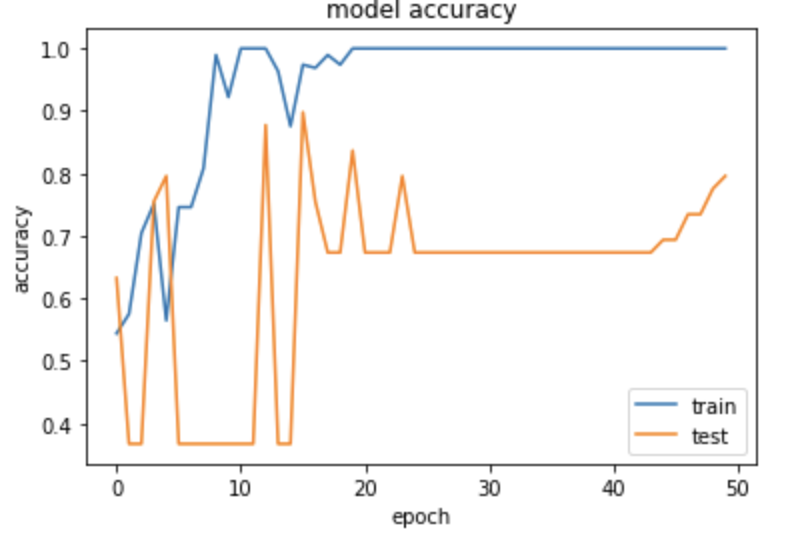

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.python.keras.models import load_model


In [ ]:
k_mer_dict = dict()

def get_history_graph(_history):
  # Model Performance (Measurement = Accuracy)
  plt.plot(_history.history['accuracy'])
  plt.plot(_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc = 'lower right') 
  plt.show()
  print(f"Final Validation Accuracy: {_history.history['val_accuracy'][-1]}")

def init_kmer():
  global k_mer_dict
  k_mer = []
  for i in product(['A', 'T', 'G', 'C', 'D'],repeat=3):
      k_mer.append(''.join(i))
      #print(i, end=" ")
  #print(k_mer)
  k_mer = pd.DataFrame(k_mer)
  ohencoder = OneHotEncoder()
  ohencoder.fit(k_mer)
  k_mer_oh = ohencoder.transform(k_mer).toarray()

  k_mer_dict = dict()
  for i in range(125):
    k_mer_dict[k_mer[0][i]] = k_mer_oh[i]

  #res_list = []
  for i in range(125):
    k_mer_dict[k_mer[0][i]] = list(map(int, (k_mer_dict[k_mer[0][i]])))
  return None

def make_cnn_model():
  cnn_model = models.Sequential()

  cnn_model.add(layers.Conv2D(16,(2,2), padding='same', input_shape=(5597,125,1)))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Activation("relu"))
  cnn_model.add(layers.MaxPooling2D((2,2)))

  cnn_model.add(layers.Conv2D(16,(2,2), padding='same'))
  cnn_model.add(layers.BatchNormalization())
  cnn_model.add(layers.Activation("relu"))
  cnn_model.add(layers.Dropout(0.2))
  cnn_model.add(layers.MaxPooling2D((2,2)))

  cnn_model.add(layers.Flatten())

  cnn_model.add(layers.Dense(units = 100, activation = "relu"))
  cnn_model.add(layers.Dense(units = 2, activation = "sigmoid"))
  cnn_model.summary()
  return cnn_model

def fit(_model, _batch_size, _epochs):
  opt = optimizers.SGD(learning_rate=0.1)
  _model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics=['accuracy'])
  _history = _model.fit(trnx.reshape(-1,5597,125,1), trny, validation_data = [tstx.reshape(-1,5597,125,1),tsty], batch_size= _batch_size, epochs = _epochs)
  return _history

def sequence_to_onehot2(_datax):
  res_list = []
  for i in range(len(_datax)):
    tmp =list()
    for j in range(len(_datax[i])-3):
      tmp.append(k_mer_dict[str(_datax[i][j:j+3])])
    res_list.append(np.array(tmp))
  res_np = np.array(res_list)
  return res_np
  

In [ ]:
init_kmer()

# data shuffle
df_shuffled = pd.read_csv('data_240.csv').sample(frac=1).reset_index(drop=True)

# x, y 분류. numpy로 변환 후 1차원으로 reshape, sequence onehot encoding
datax = sequence_to_onehot2(df_shuffled.iloc[:,[0,]].to_numpy().reshape(-1))
datay = pd.get_dummies(df_shuffled, columns=['label'])[['label_0','label_1']][:] 
datay.head(15)

# Train, Test Split 
trnx, tstx, trny, tsty = train_test_split(datax, datay, test_size = 0.2, random_state =111)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 5597, 125, 16)     80        
                                                                 
 batch_normalization_8 (Batc  (None, 5597, 125, 16)    64        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 5597, 125, 16)     0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2798, 62, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 2798, 62, 16)      1040      
                                                                 
 batch_normalization_9 (Batc  (None, 2798, 62, 16)    

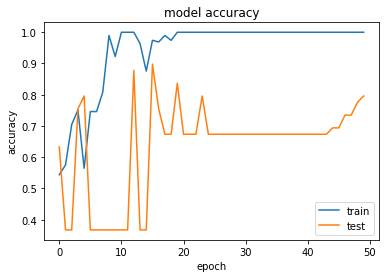

Final Validation Accuracy: 0.795918345451355


In [ ]:
cnn_model = make_cnn_model()
get_history_graph(fit(cnn_model,30,50))
